#### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# From sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Reading pre-processed data:

In [2]:
customers = pd.read_csv('data/customers_scaled.csv')
customers.drop(['Unnamed: 0'], axis = 1, inplace = True)
customers.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0,CUSTOMER_GROUP,PRODUCT_GROUP,ONLINE_PURCHASE
0,-0.971232,-0.136464,-0.460647,-0.405415,0.066823,-0.457344,-0.303045,-2.307988,-0.550257,0.443594,...,-0.328443,-0.543563,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,MULTI_BUYER,COSMETIC_AND_FOOD,0
1,1.322701,-1.112826,-0.258584,-0.405415,0.853340,-0.236872,-0.303045,0.759038,-0.066279,0.443594,...,-0.328443,1.839714,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,SINGLE_BUYER,FOOD,0
2,-0.971232,-1.763735,-0.460647,-0.405415,-0.719693,-0.457344,-0.303045,-0.263304,1.385656,1.114571,...,-0.328443,-0.543563,3.88757,-0.367167,-0.309555,-0.421484,-0.371684,MULTI_BUYER,COSMETIC_AND_FOOD,0
3,-0.971232,-0.461918,-0.528001,-0.405415,-1.506210,-0.457344,-0.303045,-2.307988,1.385656,1.114571,...,-0.328443,1.839714,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684,MULTI_BUYER,COSMETIC,0
4,-0.971232,0.514445,-0.056522,-0.405415,1.639856,-0.016400,-0.303045,-0.263304,-0.550257,0.443594,...,-0.328443,-0.543563,-0.25723,-0.367167,3.230439,-0.421484,-0.371684,MULTI_BUYER,FOOD,0


In [3]:
azdias = pd.read_csv('data/azdias_scaled.csv')
azdias.drop(['Unnamed: 0'], axis = 1, inplace = True)
azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_KATALOGNUTZER,...,REGIOTYP_7.0,CAMEO_DEUG_2015_1.0,CAMEO_DEUG_2015_2.0,CAMEO_DEUG_2015_3.0,CAMEO_DEUG_2015_4.0,CAMEO_DEUG_2015_5.0,CAMEO_DEUG_2015_6.0,CAMEO_DEUG_2015_7.0,CAMEO_DEUG_2015_8.0,CAMEO_DEUG_2015_9.0
0,-0.111007,-1.112826,-0.258584,3.036168,1.639856,-0.236872,3.329521,0.759038,-0.066279,1.114571,...,-0.322464,-0.205798,-0.320952,-0.328443,1.839714,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684
1,1.322701,1.653534,0.212895,-0.405415,0.066823,0.351053,-0.303045,-0.263304,0.901677,-1.569339,...,-0.322464,-0.205798,-0.320952,-0.328443,-0.543563,-0.25723,-0.367167,-0.309555,2.372570,-0.371684
2,1.322701,1.002626,0.145541,-0.405415,-0.719693,-0.016400,-0.303045,-0.263304,-1.034235,-0.898362,...,-0.322464,-0.205798,-0.320952,-0.328443,1.839714,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684
3,-0.971232,0.351718,-0.460647,-0.405415,-1.506210,-0.383853,-0.303045,-1.285646,-0.066279,-0.227384,...,-0.322464,-0.205798,3.115734,-0.328443,-0.543563,-0.25723,-0.367167,-0.309555,-0.421484,-0.371684
4,-0.971232,0.514445,-0.325938,-0.405415,1.639856,-0.310363,-0.303045,0.759038,-1.034235,-0.227384,...,-0.322464,-0.205798,-0.320952,-0.328443,-0.543563,-0.25723,2.723555,-0.309555,-0.421484,-0.371684


In [4]:
set(customers.columns) - set(azdias.columns)

{'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'}

In [5]:
set(azdias.columns)- set(customers.columns)

set()

In [6]:
customers_att = customers.iloc[:, :-3]

### Principal component analysis

In [7]:
#N_COMPONENTS = 200
pca = PCA() 

# Transform features
azdias_pca = pca.fit_transform(azdias)

In [8]:
# Explained variante ratio of each component
exp_variance = pca.explained_variance_ratio_

cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

In [9]:
pca.n_components_

259

Text(26, 0.2566994620820914, 'explained_variance = 50%')

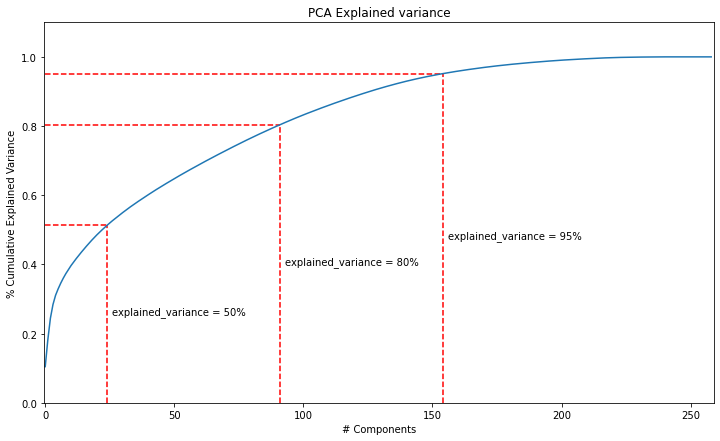

In [10]:
plt.figure(figsize=(12,7))
plt.plot(cumsum_variance)
plt.ylabel('% Cumulative Explained Variance')
plt.xlabel('# Components')
plt.title('PCA Explained variance')
plt.ylim(0, 1.1)
plt.xlim(-0.4, pca.n_components_)

# 95% explained variance
components_95 = (cumsum_variance <= 0.95).sum() + 1
plt.vlines(x = components_95, ymin = 0, ymax = cumsum_variance[components_95], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_95], xmin=0, xmax=components_95, color='red', linestyles='--')
plt.text(x = components_95 + 2, y = cumsum_variance[components_95] / 2, s = 'explained_variance = 95%' )


# 80% explained variance
components_80 = (cumsum_variance <= 0.80).sum() + 1
plt.vlines(x = components_80, ymin = 0, ymax = cumsum_variance[components_80], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_80], xmin=0, xmax=components_80, color='red', linestyles='--')
plt.text(x = components_80 + 2, y = cumsum_variance[components_80] / 2, s = 'explained_variance = 80%' )

# 50% explained variance
components_50 = (cumsum_variance <= 0.50).sum() + 1
plt.vlines(x = components_50, ymin = 0, ymax = cumsum_variance[components_50], color='red', linestyles='--')
plt.hlines(y=cumsum_variance[components_50], xmin=0, xmax=components_50, color='red', linestyles='--')
plt.text(x = components_50 + 2, y = cumsum_variance[components_50] / 2, s = 'explained_variance = 50%' )

### Component interpretation

In [11]:
def display_component(v, features_list, component_num, n_weights=10):
    global n_components
    
    # get index of component (last row - component_num)
    row_idx = len(v) - component_num

    # get the list of weights from a row in v, dataframe
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)

    # match weights to features in counties_scaled dataframe, using list comporehension
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])

    # we'll want to sort by the largest n_weights
    # weights can be neg/pos and we'll sort by magnitude
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # display using seaborn
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

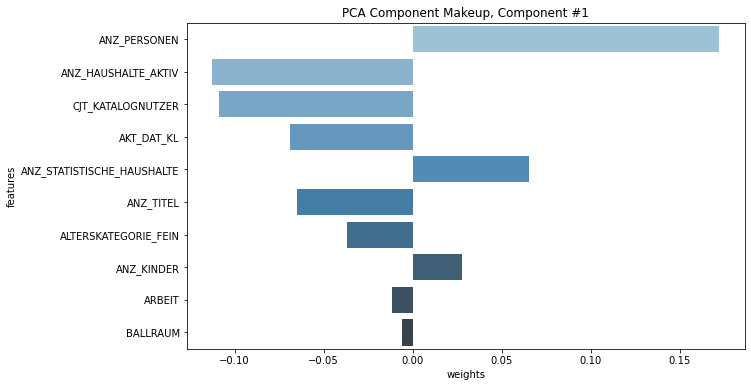

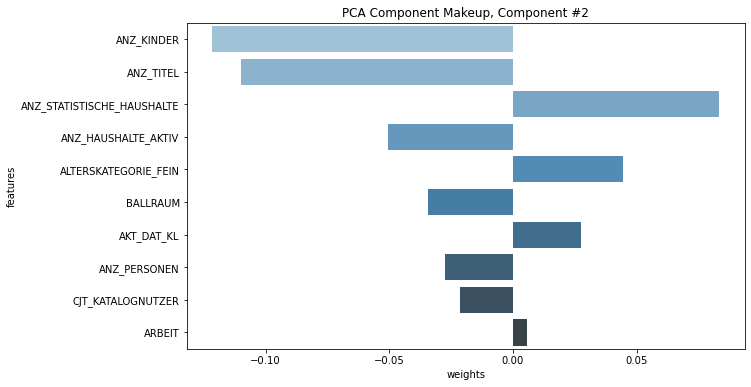

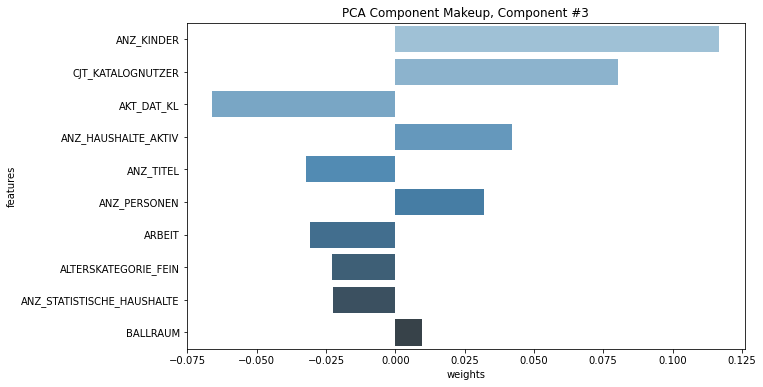

In [12]:
pca = PCA(10) 

# Transform features
azdias_pca = pca.fit_transform(azdias)

# display makeup of the first three components
display_component(pd.DataFrame( pca.components_ ), azdias.columns.values, component_num = 1, n_weights = 10)
display_component(pd.DataFrame( pca.components_ ), azdias.columns.values, component_num = 2, n_weights=10)
display_component(pd.DataFrame( pca.components_ ), azdias.columns.values, component_num = 3, n_weights=10)

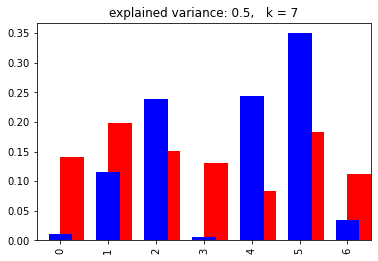

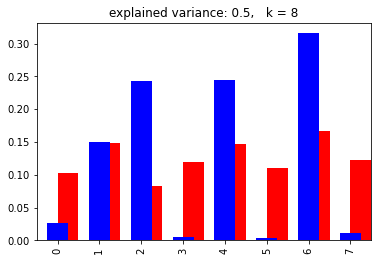

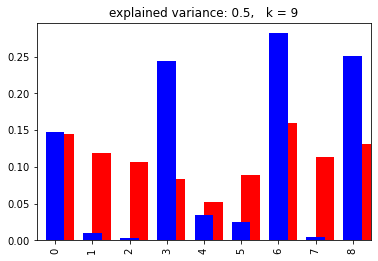

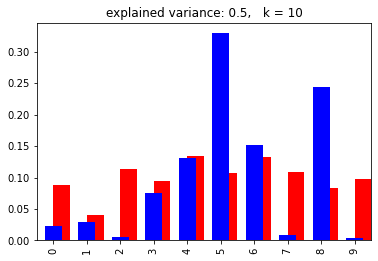

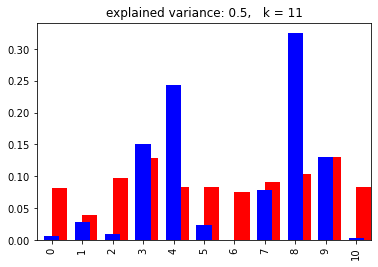

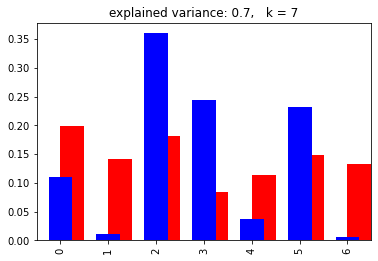

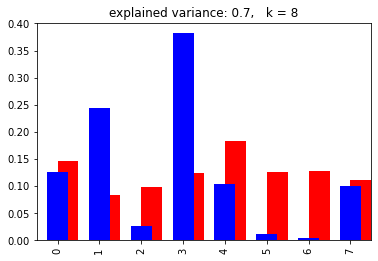

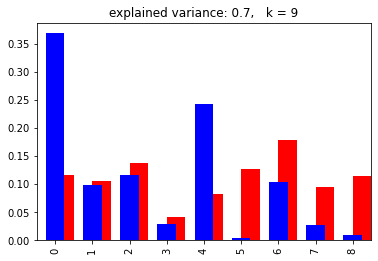

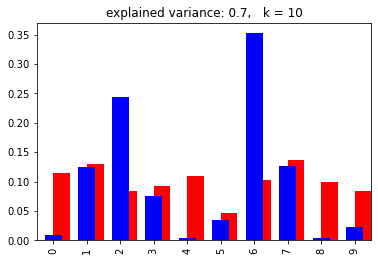

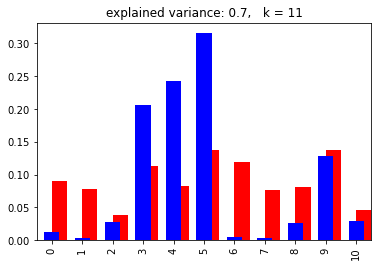

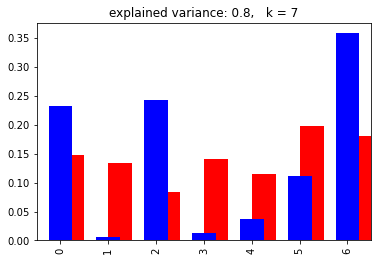

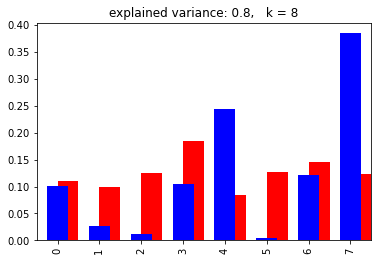

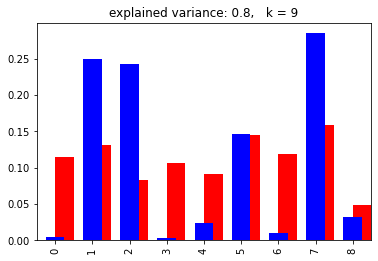

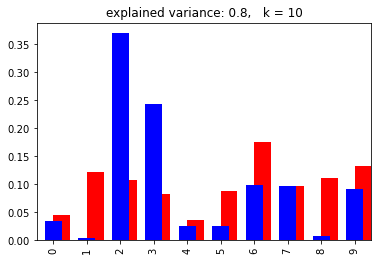

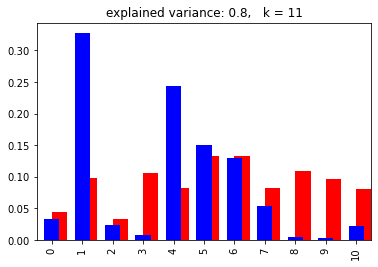

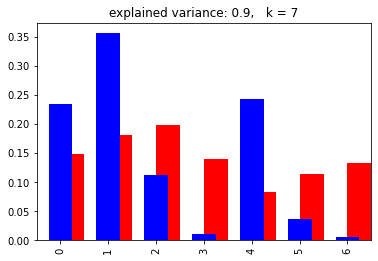

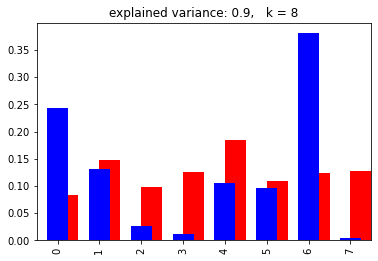

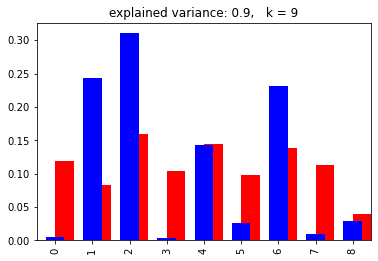

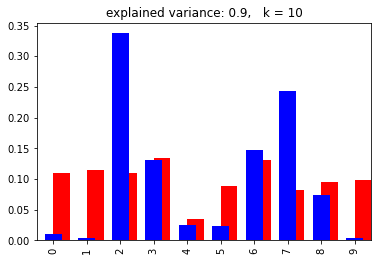

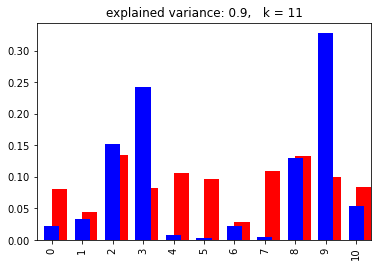

In [13]:
explained_variance = [0.5, 0.7, 0.8, 0.9]
k_list = [7, 8, 9, 10, 11]

for var in explained_variance:
    pca = PCA(var) 
    
    # Transform features
    azdias_pca = pca.fit_transform(azdias)
    
    for k in k_list:
        plt.figure()
        kmeans = KMeans(k)
        clusters = kmeans.fit(azdias_pca)
        preds_azdias = clusters.predict(azdias_pca)
        pd.Series(preds_azdias).value_counts(normalize = True).sort_index().plot.bar(color = 'red', width = 0.5, align = 'edge')
        plt.title('explained variance: {},   k = {}'.format(var, k))
        
        
        # Transform customers
        customers_pca = pca.transform(customers_att)
        preds_customers = clusters.predict(customers_pca)
        pd.Series(preds_customers).value_counts(normalize = True).sort_index().plot.bar(color = 'blue', width = 0.5, align = 'center')
        plt.show()

### Clustering

We will cluster the general population and then see in which clusters the customers' subset is.

We will use a PCA with a explained_variance of 90%.

In [14]:
pca = PCA(n_components = 0.9) 

# Transform features
azdias_pca = pca.fit_transform(azdias)

### Elbow method for *k* selection

In [15]:
scores = []
min_k = 2
max_k = 20

for k in range(min_k, max_k + 1):
    print(k)
    kmeans = KMeans(k)
    clusters = kmeans.fit(azdias_pca)
    scores.append( clusters.inertia_ )

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


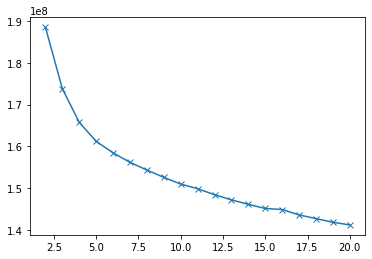

In [16]:
plt.plot(range(2,21), scores, marker = 'x')

<AxesSubplot:>

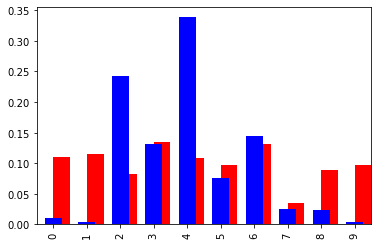

In [37]:
# Selecting k = 10
k = 10

kmeans = KMeans(k)
clust_model = kmeans.fit(azdias_pca)

# Applying reduction to customers
customers_pca = pca.transform(customers_att)

# Clusters for customers and azdias
azdias_clusters = clust_model.predict(azdias_pca)
customer_clusters = clust_model.predict(customers_pca)

# Plotting
pd.Series(azdias_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'red', width = 0.5, align = 'edge')
pd.Series(customer_clusters).value_counts(normalize = True).sort_index().plot.bar(color = 'blue', width = 0.5, align = 'center')

#### Cluster analysis

Group elements from two or more very different groups of people and compare some essential features, such as sex, or the ones from the PCA interpretation images.

We will compare subjects from cluster 1 (mostly non-customer type persons) with subjects from cluster 4 (customers are overrepresented). 

In [179]:
cluster_under = 1
cluster_over = 4

In [288]:
def compare_distribution(column, norm = True):
    azdias_u = azdias[azdias_clusters == cluster_under]
    customers_u = customers_att [customer_clusters == cluster_over]
    
    azdias_o = azdias[azdias_clusters == over_rep_cluster]
    customers_o = customers_att[customer_clusters == over_rep_cluster]
    
    #bar_comparison(azdias_u, customers_u, 'ALTER', 'underrepresented')
    #bar_comparison(azdias_o, customers_o, 'ALTER', 'overrepresented')
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fig.set_size_inches(12, 5)
    
    if len(azdias_u[column].unique()) > 10:
        series_1 = azdias_u[column].value_counts(bins = 5, normalize = norm).sort_index()
        series_2 = customers_u[column].value_counts(bins = 5, normalize = norm).sort_index()
        ax1.bar(range(1, len(series_1) + 1), series_1.values, width = 0.25, align = 'edge', color = 'red')
        ax1.bar(range(1, len(series_1) + 1), series_2.values, width = -0.25, align = 'edge', color = 'blue')
        ax1.legend(['azdias', 'customers'])
        ax1.set_title('Cluster {} (underestimated customers)'.format(cluster_under))
        ax1.set_ylim([0,1])
        
        series_3 = azdias_o[column].value_counts(bins = 5, normalize = norm).sort_index()
        series_4 = customers_o[column].value_counts(bins = 5, normalize = norm).sort_index()
        ax2.bar(range(1, len(series_3) + 1), series_3.values, width = 0.25, align = 'edge', color = 'red')
        ax2.bar(range(1, len(series_4) + 1), series_4.values, width = -0.25, align = 'edge', color = 'blue')
        ax2.legend(['azdias', 'customers'])
        ax2.set_title('Cluster {} (overestimated customers)'.format(cluster_under))
        ax2.set_ylim([0,1])
        
    else: 
        series_1 = azdias_u[column].value_counts(normalize = norm).sort_index()
        series_2 = customers_u[column].value_counts(normalize = norm).sort_index()
        ax1.bar(range(1, len(series_1) + 1), series_1.values, width = 0.25, align = 'edge', color = 'red')
        ax1.bar(range(1, len(series_1) + 1), series_2.values, width = -0.25, align = 'edge', color = 'blue')
        ax1.legend(['azdias', 'customers'])
        ax1.set_title('Cluster {} (underestimated customers)'.format(cluster_over))
        ax1.set_ylim([0,1])

        
        series_3 = azdias_o[column].value_counts(normalize = norm).sort_index()
        series_4 = customers_o[column].value_counts(normalize = norm).sort_index()
        ax2.bar(range(1, len(series_3) + 1), series_3.values, width = 0.25, align = 'edge', color = 'red')
        ax2.bar(range(1, len(series_4) + 1), series_4.values, width = -0.25, align = 'edge', color = 'blue')
        ax2.legend(['azdias', 'customers'])
        ax2.set_title('Cluster {} (overestimated customers)'.format(cluster_over))
        ax2.set_ylim([0,1])

### Age and Gender

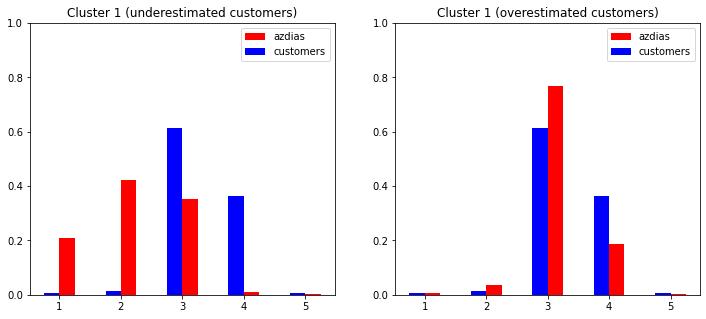

In [274]:
compare_distribution('ALTER')

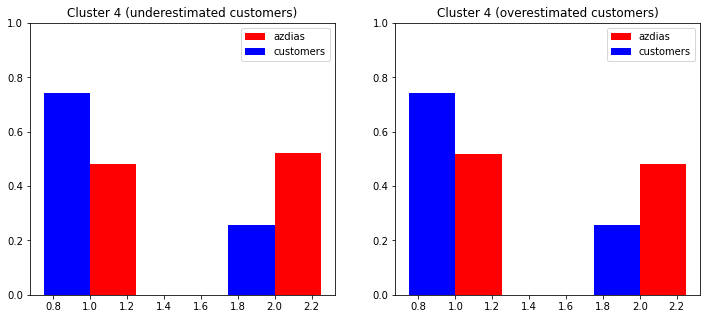

In [275]:
compare_distribution('ANREDE_KZ')

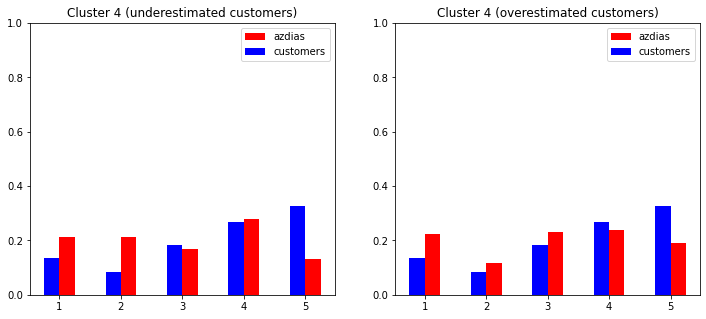

In [289]:
compare_distribution('CJT_KATALOGNUTZER')

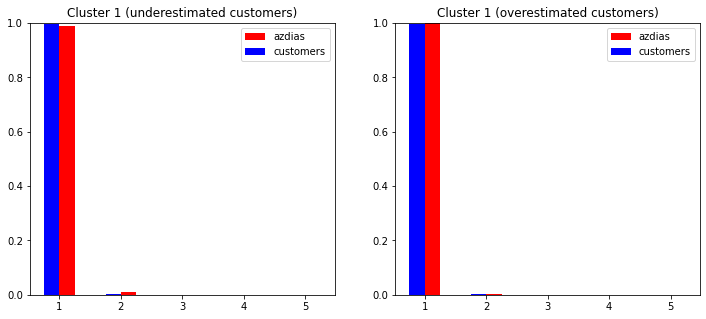

In [276]:
compare_distribution('ANZ_STATISTISCHE_HAUSHALTE')

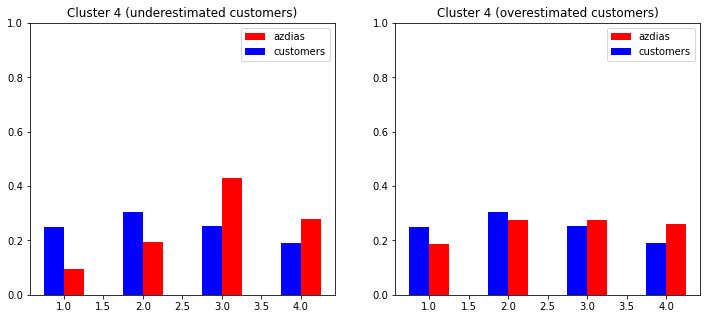

In [278]:
compare_distribution('KKK')

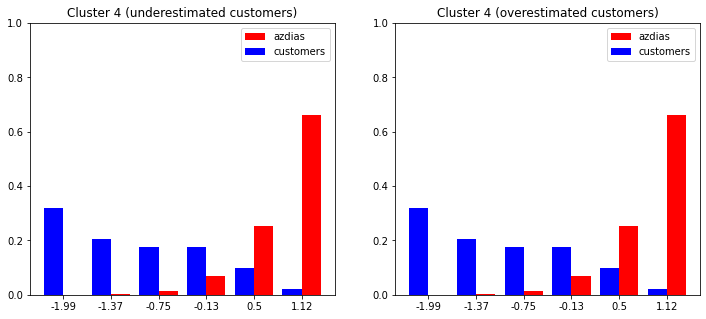

In [252]:
compare_distribution('HH_EINKOMMEN_SCORE')

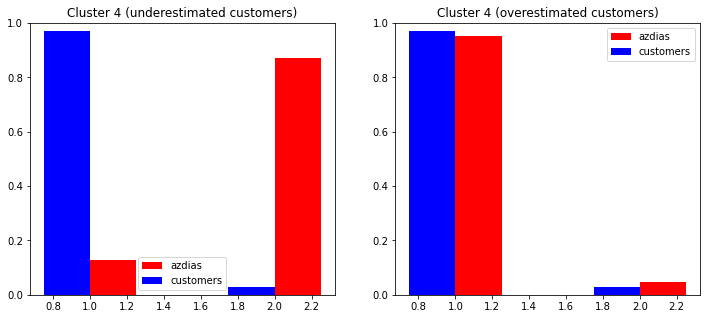

In [279]:
compare_distribution('LP_STATUS_GROB_1.0')

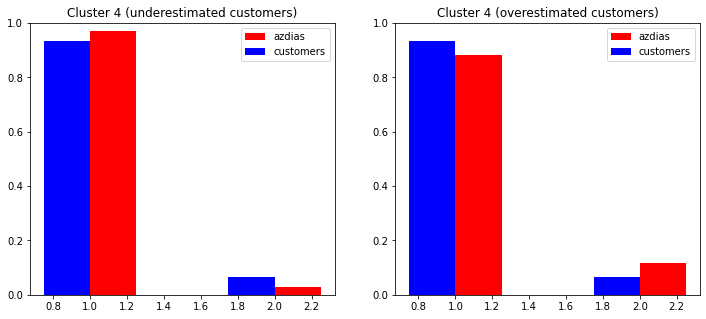

In [280]:
compare_distribution('D19_KONSUMTYP_6.0')

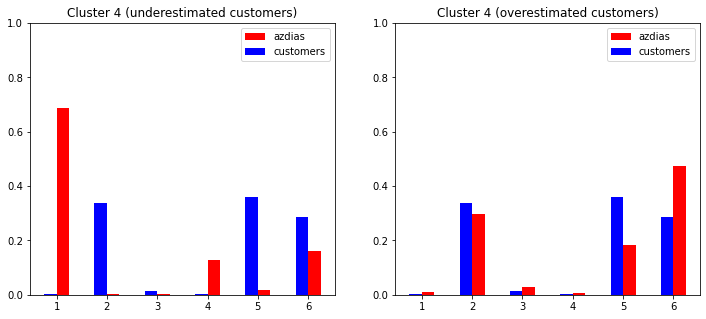

In [281]:
compare_distribution('FINANZTYP')

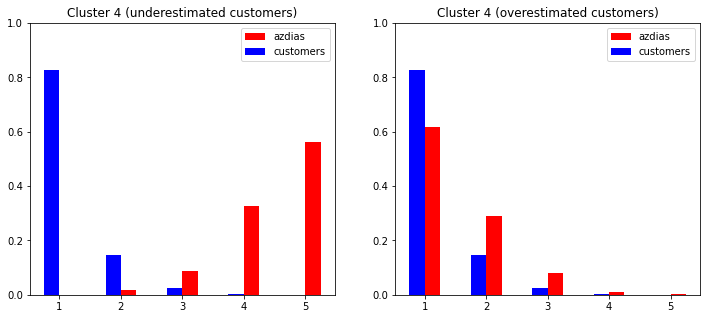

In [282]:
compare_distribution('FINANZ_SPARER')